#Week8 

This weeek's tutorial provides an introduction into **Sampling and Monte Carlo inference**.


In [8]:
## to view 3D scatterplots in a new window (and be able to rotate the plot),
## restart this notebook, comment the next line, uncomment the following one and then run this cell
%pylab inline
#from pylab import *

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [9]:
import matplotlib.pyplot as pl
import numpy as np


##What you should know before solving the challenges:
 - Basic sampling algorithms:
         standard sampling
         rejection sampling
         importance sampling
 - Gibbs sampling
 - MCMC - Markov Chain Monte Carlo    
 - Metropolis-Hastings algorithm
 

#Challenges

###1. Basic sampling algorithms

- Write a function that predicts the value of $\pi$ with an accuracy of 4 decimals using standard sampling.

In [10]:
def my_f(point):
    if point[0]**2+point[1]**2<=1:
        return 1
    return 0

def predict_pi(accuracy=0.0001):
    nr_samples = 1000000
    samples = []
    while len(samples)<nr_samples:
        x = np.random.uniform(-1,1)
        y = np.random.uniform(-1,1)
        samples.append([x,y])
    expected_value = 0
    for i in range(nr_samples):
        expected_value += my_f(samples[i])
    expected_value /= float(nr_samples)
    print(expected_value*4)
predict_pi()

3.14114


- (ARS) Suppose we would like to draw data from several distributions. Complete the code below and using ARS(Adaptive Rejection Sample) sample from the following distributions:
  - normal distribution with $\mu = 3, \sigma = 4$
  - gamma distribution with $shape=3, scale = 0.5$
  - beta distribution with $\alpha=18, \beta = 64.4$
  
  - Does the fact that the distributions are log-concave matter?
  - [Bonus]: write a model of ARS that only uses two tangent points to build the envelope function. What is the acceptance rate for , let's say, the beta distribution above? What are the optimum points that give the maximum acceptance rate?


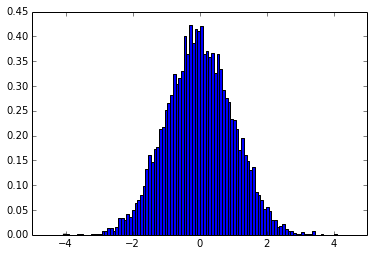

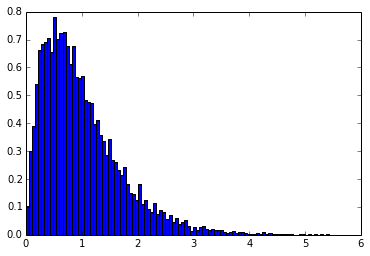

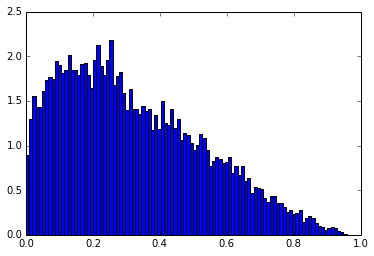

In [4]:
from __future__ import  division
import numpy as np
from matplotlib import pyplot as plt

#implementation of ARS - you might want to heck it out
from ars import ARS

######################################
# Example 1: sample 10000 values 
# from the normal distribution N(0,1)
######################################
def f(x, mu=0, sigma=1):
    return -(x-mu)**2 / (2*sigma**2)

def fprima(x, mu=0, sigma=1):
    return -(x-mu) / sigma**2

x = np.linspace(-100,100,100)
ars = ARS(f, fprima, xi = [-4,1,40], mu=0, sigma=1)
samples = ars.draw(10000)
plt.hist(samples, bins=100, normed=True)
plt.show()


######################################
# Example 2: sample 10000 values 
# from a gamma(2,0.5)
######################################
def f(x, shape, scale=1):
    return (shape-1)*log(x) - x/scale


def fprima(x, shape, scale=1):
    return (shape-1)/x - 1/scale

x = np.linspace(-100,100,100)
ars = ARS(f, fprima, xi = [0.1,1,40], lb=0, shape=2, scale=0.5)
samples = ars.draw(10000)
plt.hist(samples, bins=100, normed=True)
plt.show()


######################################
# Example 3: sample 10000 values 
# from a beta(1.3,2.7) distribution
######################################
def f(x, a=1.3, b=2.7):
    return (a-1)*log(x)+(b-1)*log(1-x)


def fprima(x, a=1.3, b=2.7):
    return (a-1)/x - (b-1)/(1-x)

x = np.linspace(-100,100,100)
ars = ARS(f, fprima, xi = [0.1, 0.6], lb=0, ub=1, a=1.3, b=2.7)
samples = ars.draw(10000)
plt.hist(samples, bins=100, normed=True)
plt.show()

###2. MCMC - Markov Chain Monte Carlo

#### - Let $\pi(x) = \frac{10^x}{x!}e^{-10}$ be our distribution ($P(X = x) = \pi(x)$) that we want to draw samples from. Also let the markov chain kernel that we are going to use to be: \begin{equation} 
    P(x_{i+1} = x_i -1 | x_i) =
      \begin{cases}
    x_i/20 & \quad \text{if } x_i \leq 9\\
    1/2 & \quad \text{if } x_i > 9\\
      \end{cases} \\
    P(x_{i+1} = x_i| x_i) = 
      \begin{cases}
    (10 - x_i)/20 & \quad \text{if } x_i \leq 9\\
    (x_i - 9)/2(x_i + 1) & \quad \text{if } x_i > 9\\
      \end{cases} \\
    P(x_{i+1} = x_i +1 | x_i) =
      \begin{cases}
    1/2 & \quad \text{if } x_i \leq 9\\
    5/(x_i +1) & \quad \text{if } x_i > 9\\
      \end{cases}
    \end{equation}
   - By setting $x_0$ to $0,1, \text{ or } 2$ with probability $1/3$ for each **find the number** $m$ such that $x_m, x_{m+1}, x_{m+2} $ sampled with the MCMC algorithm are essentially the same as when sampled from the initial distribution. Explain your choice of $m$. 
   - *Bonus* (Matplotlib guru): animate the process so that you can better see how MCMC aproximates the given distribution :) 

Consider the transition matrix T. (i,j) in T^n = probability of landing on state J after being on state I, in exactly N stepts. 

Now if we define the initial probability Init =(1/3,1/3,1/3,0,0....) then Init * T^n = the probability of ending in each state after N steps considering the initial probability. 

So we search for an m such that euclidian_distance(Init * T^m,Pi) < epsilon, where Pi = the true distribution. Setting epsilon = 0.00000000001, the inequality is satisfied when M = 585 

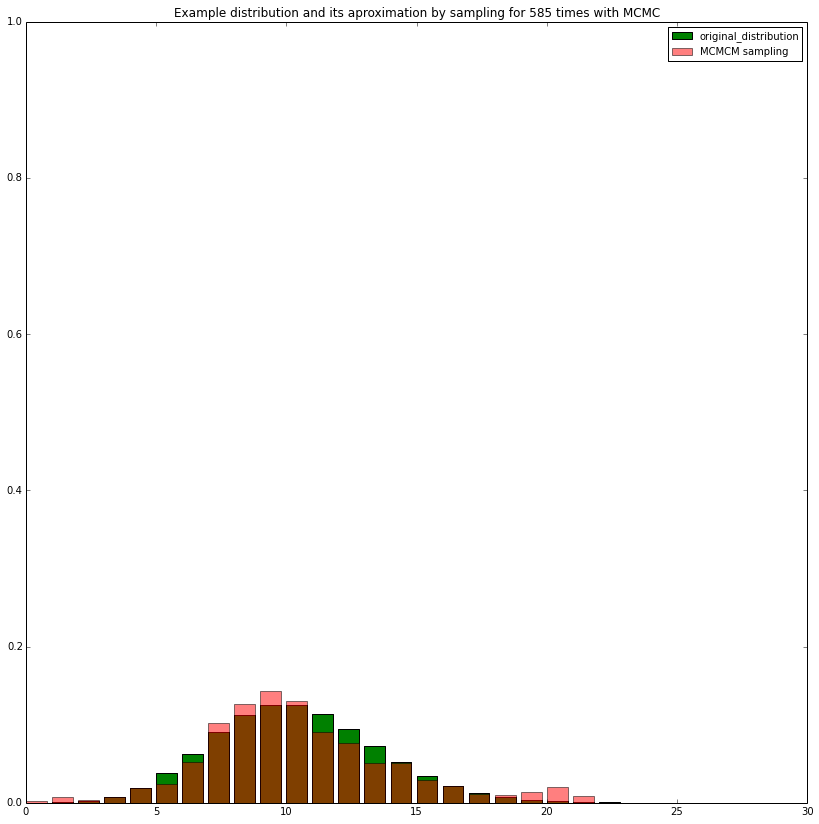

In [12]:
from random import choice, seed
import numpy as np
from math import factorial, exp, pow
import matplotlib.pyplot as plt
from scipy.stats import rv_discrete

'''
Find an M below such that the two bar grapsh overlap :)
'''
seed(42)
M = 585
f = plt.figure(figsize=(14,14))

def sample_from_distribution(N=10):
    prob_custom_distrib = []
    sample = []
    for i in range (30):
        prob_custom_distrib.append(pow(10,i)/factorial(i)*exp(-10))
        sample += [i for j in range(int(prob_custom_distrib[i]*100.0))]
    result = []
    for i in range(N):
        result.append(choice(sample))
    return result

def prob_same(x):
    if x <=9:
        return (10-x)/20.0
    else:
        return (x-9)/(2.0*(x+1))
def prob_less(x):
    if x <= 9 :
        return x/20.0
    else:
        return 1/2.0
def prob_greater(x):
    if x <= 9:
        return 1/2.0
    else:
        return 5.0/(x+1)
    
def build_probabilities_from_samples(samples):
    no_samples = len(samples)
    return np.array([[i,(samples.count(i)+0.0)/no_samples ] for i in set(samples)])
    
def sample_from_MC(x,N=100):
    same = int(prob_same(x)*N)
    less = int(prob_less(x)*N)
    greater = int(prob_greater(x)*N)
    #print same,less,greater
    sample = [x for i in range(same)] + \
                 [x-1 for i in range(less)] + \
                 [x+1 for i in range(greater)] 
    #print sample
    return choice(sample)
                          
def run_for_m(m):
    samples = [0,1,2] #x_0
    
    current_sample = choice(samples) #pick one with prob 1/3  
    for i in range(m):
        samples.append(sample_from_MC(current_sample))
        current_sample = samples[-1]
    #print samples
    result = build_probabilities_from_samples(samples)
    #print result
    return result

def plot_bar(samples_MCMC,show=False):
    n_bins = 30
    im = []
    prob = sample_from_distribution(100)
    plt.hold(True)
    ax0 = f.add_subplot(111,)
    custom_distribution = np.zeros([30,2])
    for i in range (30):
            custom_distribution[i][0] = pow(10.0,i)/factorial(i)*exp(-10.0)
            custom_distribution[i][1] = i

    plt.bar(custom_distribution[:,1],custom_distribution[:,0],color='green', label='original_distribution')
    plt.bar(samples_MCMC[:,0],samples_MCMC[:,1],color='red',alpha=0.5,label='MCMCM sampling')
    plt.legend(prop={'size': 10})
    ax0.set_title('Example distribution and its aproximation by sampling for %d times with MCMC'%M)
    plt.axis([0,30,0,1])
    if show:
        plt.show()
    return plt

##main
s = run_for_m(M)
im = plot_bar(s,show=True)

###3. Metropolis-Hastings Algorithm

- A bit of history(1953). "Hard Disks in a box" model. The problem is how to simulate a number of N disks(spheres in 3D) in a closed square(cube in 3D). One can use a sampling method to choose where our sphere/particle can move next.
 - What is the difference between the two sampling methods presented below?
 - Which one do you think provides a better model for our problem?
 - What is the proposal for our Metropolis algorithm?
 - (Coding task)Write your own model that uses Gibbs sampling to solve this problem

In [1]:
#direct sampling
from random import uniform
 
def dist(x,y):
    return  (x[0] - y[0])**2 + (x[1] - y[1]) ** 2
N = 4
sigma = 0.2; sigma_sq = sigma**2
condition = False
while condition == False:
    L = [(uniform(sigma, 1 - sigma), uniform(sigma, 1 - sigma))]
    for k in range(1,N):
        b = (uniform(sigma, 1 - sigma), uniform(sigma, 1 - sigma))
        min_dist = min(dist(b, x) for x in L)
        if min_dist < 4 * sigma_sq:
            condition = False
            break
        else:
            L.append(b)
            condition = True
print L



[(0.7548075391511717, 0.7464623927522203), (0.2715441581368901, 0.7551326126635136), (0.760833211130848, 0.25634868525014554), (0.25644261821728104, 0.3149937039819776)]


In [3]:
#local metropolis algorithm
from random import uniform as ran, choice
 
L = [(0.25, 0.25), (0.75, 0.25), (0.25, 0.75), (0.75, 0.75)]
sigma = 0.20; sigma_sq = sigma**2
delta = 0.05
f = plt.figure(figsize=(14,14))
ax = f.add_subplot(111,)
plt.xlim(0,1)
plt.ylim(0,1)
im = []
plt.hold(True) 

for iter in range(300):
    x = [[],[],[],[]]
    y = [[],[],[],[]]
    a = choice(L)
    L.remove(a)
    b = (a[0] + ran(-delta, delta), a[1] + ran(-delta, delta))
    min_dist = min((b[0] - x[0]) ** 2 + (b[1] - x[1]) ** 2 for x in L)
    box_cond = min(b[0],b[1]) < sigma or max(b[0], b[1]) > 1 - sigma
    if box_cond or min_dist < 4 * sigma ** 2:
        L.append(a)
    else:
        L.append(b)
     
    for i in range(len(L)):
        (x_i,y_i) = L[i]
        x[i].append(x_i)
        y[i].append(y_i)
    im.append((plt.scatter(x,y,s=80000),))

print L

[(0.30778344298311633, 0.7580136947139562), (0.7778888750164206, 0.2709762012341282), (0.7438361763745374, 0.7036444860603471), (0.3340164586704258, 0.2981984300549168)]


In [4]:
# It will take some time :) about 3-4 minutes or so until the video is generated.
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)

im_ani = animation.ArtistAnimation(f, im, interval=100, repeat_delay=3000,
                                   blit=True)
im_ani.save('disks.mp4', writer=writer )

In [5]:
#Might not work in any browser
def video(fname, mimetype):
    from IPython.display import HTML
    video_encoded = open(fname, "rb").read().encode("base64")
    video_tag = '<video controls alt="test" src="data:video/{0};base64,{1}">'.format(mimetype, video_encoded)
    return HTML(data=video_tag)

video("disks.mp4", "mp4")

###5. AAAAAAAAND DONE!

In [ ]:
print "Done"

###Bonus

- TODO